In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())


In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in MI feature selection method
feature_names = ['CoExpression', 'PCC', 'PPI', 'Root10DaysSeedling', 'Leaf21DaysSeedling', 
                 'Leaf45DaysOldPlant', 'log_2FoldChange', 'ET', 'Shoot10DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot35DaysSeedling', 'Shoot14DaysSeedling', 'Root17DaysSeedling', 'Shoot17DaysSeedling', 'Shoot21DaysSeedling', 
                 'Root24DaysSeedling', 'Root14DaysSeedling', 'Root21DaysSeedling', 'Root52DaysSeedling', 'Root35DaysSeedling']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X_fs.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
1.0      1800
2.0      1296
3.0      1260
4.0      1218
5.0      1026
6.0      1008
7.0       930
8.0       912
9.0       880
10.0      798
11.0      792
12.0      759
13.0      729
14.0      720
15.0      702
16.0      693
17.0      672
18.0      640
19.0      625
20.0      570
21.0      546
22.0      506
23.0      483
24.0      448
25.0      432
26.0      384
27.0      360
28.0      360
29.0      320
30.0      312
         ... 
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      12
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      11
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
373.0      10
Length: 373, dtype: int64


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

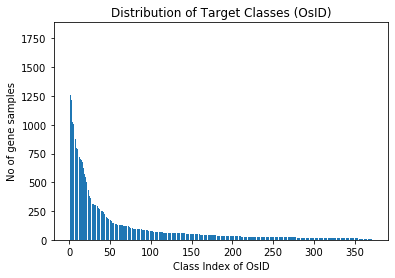

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=80, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

Number of input features: 1
Fold: 1


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 15s 4ms/step - loss: 5.0943 - accuracy: 0.0408 - val_loss: 5.0484 - val_accuracy: 0.0436
Epoch 2/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.9869 - accuracy: 0.0437 - val_loss: 5.0588 - val_accuracy: 0.0436
Epoch 3/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.9804 - accuracy: 0.0436 - val_loss: 5.0412 - val_accuracy: 0.0436
Epoch 4/80
1846/1846 [==============================] - 8s 4ms/step - loss: 4.9766 - accuracy: 0.0436 - val_loss: 5.0399 - val_accuracy: 0.0436
Epoch 5/80
1846/1846 [==============================] - 8s 4ms/step - loss: 4.9744 - accuracy: 0.0435 - val_loss: 5.0406 - val_accuracy: 0.0436
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.9715 - accuracy: 0.0440 - val_loss: 5.0400 - val_accuracy: 0.0436
Epoch 7/80
1846/1846 [==============================] - 8s 4ms/step - loss: 4.9640 - accuracy: 0.0440 - val_loss: 5.0328 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 15s 4ms/step - loss: 5.0958 - accuracy: 0.0408 - val_loss: 5.0419 - val_accuracy: 0.0436
Epoch 2/80
1846/1846 [==============================] - 8s 4ms/step - loss: 4.9809 - accuracy: 0.0440 - val_loss: 5.0337 - val_accuracy: 0.0436
Epoch 3/80
1846/1846 [==============================] - 8s 5ms/step - loss: 4.9690 - accuracy: 0.0436 - val_loss: 5.0161 - val_accuracy: 0.0524
Epoch 4/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.9154 - accuracy: 0.0508 - val_loss: 4.9708 - val_accuracy: 0.0510
Epoch 5/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.8711 - accuracy: 0.0528 - val_loss: 4.9433 - val_accuracy: 0.0515
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.8542 - accuracy: 0.0541 - val_loss: 4.9319 - val_accuracy: 0.0565
Epoch 7/80
1846/1846 [==============================] - 8s 4ms/step - loss: 4.8437 - accuracy: 0.0537 - val_loss: 4.9346 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 15s 4ms/step - loss: 5.0957 - accuracy: 0.0419 - val_loss: 5.0318 - val_accuracy: 0.0436
Epoch 2/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.9522 - accuracy: 0.0554 - val_loss: 4.9505 - val_accuracy: 0.0706
Epoch 3/80
1846/1846 [==============================] - 8s 4ms/step - loss: 4.7731 - accuracy: 0.0749 - val_loss: 4.8045 - val_accuracy: 0.0706
Epoch 4/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.6708 - accuracy: 0.0800 - val_loss: 4.7219 - val_accuracy: 0.0785
Epoch 5/80
1846/1846 [==============================] - 8s 4ms/step - loss: 4.6147 - accuracy: 0.0835 - val_loss: 4.7120 - val_accuracy: 0.0803
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.5861 - accuracy: 0.0838 - val_loss: 4.6976 - val_accuracy: 0.0774
Epoch 7/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.5666 - accuracy: 0.0853 - val_loss: 4.6783 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 9s 3ms/step - loss: 5.0505 - accuracy: 0.0404 - val_loss: 4.9766 - val_accuracy: 0.0367
Epoch 2/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.6896 - accuracy: 0.0687 - val_loss: 4.4655 - val_accuracy: 0.0935
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1974 - accuracy: 0.1155 - val_loss: 4.1699 - val_accuracy: 0.1336
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.9280 - accuracy: 0.1378 - val_loss: 3.9545 - val_accuracy: 0.1490
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7026 - accuracy: 0.1753 - val_loss: 3.7668 - val_accuracy: 0.1661
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4609 - accuracy: 0.2233 - val_loss: 3.5278 - val_accuracy: 0.2367
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.2456 - accuracy: 0.2653 - val_loss: 3.3620 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 8s 3ms/step - loss: 5.0477 - accuracy: 0.0454 - val_loss: 4.9133 - val_accuracy: 0.0713
Epoch 2/80
1846/1846 [==============================] - 4s 2ms/step - loss: 4.4306 - accuracy: 0.1037 - val_loss: 4.2003 - val_accuracy: 0.1406
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.9053 - accuracy: 0.1611 - val_loss: 3.8553 - val_accuracy: 0.1971
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5009 - accuracy: 0.2375 - val_loss: 3.4268 - val_accuracy: 0.2557
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0440 - accuracy: 0.3087 - val_loss: 3.0630 - val_accuracy: 0.3122
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6629 - accuracy: 0.3600 - val_loss: 2.7004 - val_accuracy: 0.4163
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3607 - accuracy: 0.4119 - val_loss: 2.5005 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 9s 3ms/step - loss: 5.0224 - accuracy: 0.0417 - val_loss: 4.8400 - val_accuracy: 0.0502
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 4.4102 - accuracy: 0.0962 - val_loss: 4.2107 - val_accuracy: 0.1452
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7841 - accuracy: 0.2197 - val_loss: 3.5838 - val_accuracy: 0.2612
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1367 - accuracy: 0.3222 - val_loss: 3.0515 - val_accuracy: 0.3701
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5711 - accuracy: 0.4345 - val_loss: 2.5758 - val_accuracy: 0.4669
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1245 - accuracy: 0.5095 - val_loss: 2.2574 - val_accuracy: 0.5635
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8125 - accuracy: 0.5763 - val_loss: 2.0810 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 9s 3ms/step - loss: 5.0313 - accuracy: 0.0384 - val_loss: 4.9144 - val_accuracy: 0.0363
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 4.4839 - accuracy: 0.1050 - val_loss: 4.2522 - val_accuracy: 0.1366
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.9284 - accuracy: 0.1723 - val_loss: 3.9110 - val_accuracy: 0.2053
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6136 - accuracy: 0.2179 - val_loss: 3.6761 - val_accuracy: 0.2427
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3449 - accuracy: 0.2606 - val_loss: 3.4286 - val_accuracy: 0.2645
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0633 - accuracy: 0.3112 - val_loss: 3.2167 - val_accuracy: 0.3153
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8200 - accuracy: 0.3363 - val_loss: 3.0473 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 2ms/step - loss: 4.7781 - accuracy: 0.0429 - val_loss: 4.5431 - val_accuracy: 0.0427
Epoch 2/80
1846/1846 [==============================] - 4s 2ms/step - loss: 4.3418 - accuracy: 0.0735 - val_loss: 4.2604 - val_accuracy: 0.0917
Epoch 3/80
1846/1846 [==============================] - 4s 2ms/step - loss: 4.0283 - accuracy: 0.1142 - val_loss: 3.9384 - val_accuracy: 0.1300
Epoch 4/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6453 - accuracy: 0.1943 - val_loss: 3.5643 - val_accuracy: 0.2152
Epoch 5/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2647 - accuracy: 0.2438 - val_loss: 3.1847 - val_accuracy: 0.2664
Epoch 6/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8611 - accuracy: 0.3193 - val_loss: 2.8341 - val_accuracy: 0.3446
Epoch 7/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5265 - accuracy: 0.3826 - val_loss: 2.6175 - val_accuracy: 0.4031
Epo

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.7717 - accuracy: 0.0505 - val_loss: 4.5363 - val_accuracy: 0.0906
Epoch 2/80
1846/1846 [==============================] - 4s 2ms/step - loss: 4.3024 - accuracy: 0.0916 - val_loss: 4.2404 - val_accuracy: 0.1050
Epoch 3/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.9817 - accuracy: 0.1359 - val_loss: 3.9179 - val_accuracy: 0.1421
Epoch 4/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6502 - accuracy: 0.1655 - val_loss: 3.6050 - val_accuracy: 0.1701
Epoch 5/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3280 - accuracy: 0.1976 - val_loss: 3.3469 - val_accuracy: 0.2013
Epoch 6/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0820 - accuracy: 0.2283 - val_loss: 3.1574 - val_accuracy: 0.2407
Epoch 7/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8637 - accuracy: 0.2708 - val_loss: 2.9125 - val_accuracy: 0.2975
Epo

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 2ms/step - loss: 4.7362 - accuracy: 0.0552 - val_loss: 4.5024 - val_accuracy: 0.0317
Epoch 2/80
1846/1846 [==============================] - 4s 2ms/step - loss: 4.2096 - accuracy: 0.0959 - val_loss: 4.0915 - val_accuracy: 0.1212
Epoch 3/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7731 - accuracy: 0.1512 - val_loss: 3.6485 - val_accuracy: 0.1848
Epoch 4/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2729 - accuracy: 0.2286 - val_loss: 3.2354 - val_accuracy: 0.2656
Epoch 5/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8211 - accuracy: 0.3310 - val_loss: 2.8551 - val_accuracy: 0.3063
Epoch 6/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.4340 - accuracy: 0.4149 - val_loss: 2.5033 - val_accuracy: 0.4191
Epoch 7/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.1356 - accuracy: 0.4647 - val_loss: 2.2711 - val_accuracy: 0.4893
Epo

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 2ms/step - loss: 4.7286 - accuracy: 0.0548 - val_loss: 4.3866 - val_accuracy: 0.0946
Epoch 2/80
1846/1846 [==============================] - 4s 2ms/step - loss: 4.0986 - accuracy: 0.1056 - val_loss: 3.9943 - val_accuracy: 0.1012
Epoch 3/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7319 - accuracy: 0.1372 - val_loss: 3.6782 - val_accuracy: 0.1575
Epoch 4/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3422 - accuracy: 0.1976 - val_loss: 3.2991 - val_accuracy: 0.2147
Epoch 5/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9430 - accuracy: 0.2832 - val_loss: 2.9537 - val_accuracy: 0.3017
Epoch 6/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5697 - accuracy: 0.3626 - val_loss: 2.6471 - val_accuracy: 0.3699
Epoch 7/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2585 - accuracy: 0.4187 - val_loss: 2.3839 - val_accuracy: 0.4077
Epo

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 2ms/step - loss: 4.8167 - accuracy: 0.0520 - val_loss: 4.5708 - val_accuracy: 0.0392
Epoch 2/80
1846/1846 [==============================] - 4s 2ms/step - loss: 4.2590 - accuracy: 0.0978 - val_loss: 4.1047 - val_accuracy: 0.1201
Epoch 3/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.8471 - accuracy: 0.1316 - val_loss: 3.7820 - val_accuracy: 0.1457
Epoch 4/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5228 - accuracy: 0.1679 - val_loss: 3.5067 - val_accuracy: 0.1974
Epoch 5/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2448 - accuracy: 0.2095 - val_loss: 3.2959 - val_accuracy: 0.2471
Epoch 6/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0125 - accuracy: 0.2496 - val_loss: 3.1084 - val_accuracy: 0.2906
Epoch 7/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8089 - accuracy: 0.2843 - val_loss: 2.9601 - val_accuracy: 0.3023
Epo

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.8580 - accuracy: 0.0447 - val_loss: 4.6068 - val_accuracy: 0.0768
Epoch 2/80
1846/1846 [==============================] - 4s 2ms/step - loss: 4.3486 - accuracy: 0.0957 - val_loss: 4.2214 - val_accuracy: 0.1080
Epoch 3/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.9490 - accuracy: 0.1292 - val_loss: 3.9110 - val_accuracy: 0.1540
Epoch 4/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6598 - accuracy: 0.1657 - val_loss: 3.6793 - val_accuracy: 0.1690
Epoch 5/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4293 - accuracy: 0.1908 - val_loss: 3.4819 - val_accuracy: 0.1888
Epoch 6/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2089 - accuracy: 0.2238 - val_loss: 3.2759 - val_accuracy: 0.2235
Epoch 7/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9916 - accuracy: 0.2605 - val_loss: 3.0622 - val_accuracy: 0.2726
Epo

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.8174 - accuracy: 0.0546 - val_loss: 4.5306 - val_accuracy: 0.0634
Epoch 2/80
1846/1846 [==============================] - 4s 2ms/step - loss: 4.1530 - accuracy: 0.1148 - val_loss: 4.0170 - val_accuracy: 0.1355
Epoch 3/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7322 - accuracy: 0.1481 - val_loss: 3.7027 - val_accuracy: 0.1622
Epoch 4/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4535 - accuracy: 0.1755 - val_loss: 3.4748 - val_accuracy: 0.2015
Epoch 5/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2222 - accuracy: 0.2118 - val_loss: 3.2791 - val_accuracy: 0.2319
Epoch 6/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9954 - accuracy: 0.2495 - val_loss: 3.0605 - val_accuracy: 0.2548
Epoch 7/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7204 - accuracy: 0.3122 - val_loss: 2.7729 - val_accuracy: 0.3443
Epo

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 6s 2ms/step - loss: 4.7861 - accuracy: 0.0631 - val_loss: 4.3911 - val_accuracy: 0.0944
Epoch 2/80
1846/1846 [==============================] - 4s 2ms/step - loss: 4.0015 - accuracy: 0.1292 - val_loss: 3.8595 - val_accuracy: 0.1329
Epoch 3/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5630 - accuracy: 0.1723 - val_loss: 3.4634 - val_accuracy: 0.2013
Epoch 4/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1031 - accuracy: 0.2673 - val_loss: 3.0150 - val_accuracy: 0.2895
Epoch 5/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.6642 - accuracy: 0.3645 - val_loss: 2.6449 - val_accuracy: 0.3756
Epoch 6/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.3035 - accuracy: 0.4465 - val_loss: 2.3717 - val_accuracy: 0.4746
Epoch 7/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.0134 - accuracy: 0.5175 - val_loss: 2.1264 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.8452 - accuracy: 0.0513 - val_loss: 4.5795 - val_accuracy: 0.1023
Epoch 2/80
1846/1846 [==============================] - 4s 2ms/step - loss: 4.2423 - accuracy: 0.1081 - val_loss: 4.0845 - val_accuracy: 0.1287
Epoch 3/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.8116 - accuracy: 0.1523 - val_loss: 3.7897 - val_accuracy: 0.1690
Epoch 4/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5345 - accuracy: 0.1816 - val_loss: 3.5584 - val_accuracy: 0.1806
Epoch 5/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2974 - accuracy: 0.2056 - val_loss: 3.3313 - val_accuracy: 0.2158
Epoch 6/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0552 - accuracy: 0.2455 - val_loss: 3.1208 - val_accuracy: 0.2746
Epoch 7/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8082 - accuracy: 0.2837 - val_loss: 2.9182 - val_accuracy: 0.2865
Epo

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.8084 - accuracy: 0.0573 - val_loss: 4.4750 - val_accuracy: 0.1069
Epoch 2/80
1846/1846 [==============================] - 3s 2ms/step - loss: 4.0774 - accuracy: 0.1241 - val_loss: 3.9331 - val_accuracy: 0.1105
Epoch 3/80
1846/1846 [==============================] - 3s 2ms/step - loss: 3.6521 - accuracy: 0.1737 - val_loss: 3.6112 - val_accuracy: 0.1679
Epoch 4/80
1846/1846 [==============================] - 3s 2ms/step - loss: 3.3886 - accuracy: 0.2036 - val_loss: 3.4127 - val_accuracy: 0.2161
Epoch 5/80
1846/1846 [==============================] - 3s 2ms/step - loss: 3.1734 - accuracy: 0.2297 - val_loss: 3.2947 - val_accuracy: 0.1903
Epoch 6/80
1846/1846 [==============================] - 3s 2ms/step - loss: 2.9466 - accuracy: 0.2754 - val_loss: 3.0184 - val_accuracy: 0.2867
Epoch 7/80
1846/1846 [==============================] - 3s 2ms/step - loss: 2.6976 - accuracy: 0.3235 - val_loss: 2.7936 - val_accuracy: 0.3371
Epo

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.8510 - accuracy: 0.0597 - val_loss: 4.4842 - val_accuracy: 0.0592
Epoch 2/80
1846/1846 [==============================] - 3s 2ms/step - loss: 4.0484 - accuracy: 0.1297 - val_loss: 3.8965 - val_accuracy: 0.1679
Epoch 3/80
1846/1846 [==============================] - 3s 2ms/step - loss: 3.6484 - accuracy: 0.1857 - val_loss: 3.6044 - val_accuracy: 0.2015
Epoch 4/80
1846/1846 [==============================] - 3s 2ms/step - loss: 3.3407 - accuracy: 0.2324 - val_loss: 3.3166 - val_accuracy: 0.2777
Epoch 5/80
1846/1846 [==============================] - 3s 2ms/step - loss: 3.0026 - accuracy: 0.2919 - val_loss: 3.0405 - val_accuracy: 0.3162
Epoch 6/80
1846/1846 [==============================] - 3s 2ms/step - loss: 2.6889 - accuracy: 0.3536 - val_loss: 2.7639 - val_accuracy: 0.3800
Epoch 7/80
1846/1846 [==============================] - 3s 2ms/step - loss: 2.4101 - accuracy: 0.4211 - val_loss: 2.5264 - val_accuracy: 0.4367
Epo

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.8772 - accuracy: 0.0561 - val_loss: 4.5761 - val_accuracy: 0.1012
Epoch 2/80
1846/1846 [==============================] - 3s 2ms/step - loss: 4.2132 - accuracy: 0.1145 - val_loss: 4.0578 - val_accuracy: 0.1265
Epoch 3/80
1846/1846 [==============================] - 3s 2ms/step - loss: 3.7686 - accuracy: 0.1691 - val_loss: 3.7602 - val_accuracy: 0.1624
Epoch 4/80
1846/1846 [==============================] - 3s 2ms/step - loss: 3.5199 - accuracy: 0.1967 - val_loss: 3.5550 - val_accuracy: 0.1912
Epoch 5/80
1846/1846 [==============================] - 3s 2ms/step - loss: 3.3289 - accuracy: 0.2175 - val_loss: 3.4095 - val_accuracy: 0.1965
Epoch 6/80
1846/1846 [==============================] - 3s 2ms/step - loss: 3.1648 - accuracy: 0.2375 - val_loss: 3.2585 - val_accuracy: 0.2411
Epoch 7/80
1846/1846 [==============================] - 3s 2ms/step - loss: 3.0095 - accuracy: 0.2608 - val_loss: 3.1578 - val_accuracy: 0.2462
Epo

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.8851 - accuracy: 0.0514 - val_loss: 4.5765 - val_accuracy: 0.0636
Epoch 2/80
1846/1846 [==============================] - 3s 2ms/step - loss: 4.1953 - accuracy: 0.1140 - val_loss: 4.0018 - val_accuracy: 0.1498
Epoch 3/80
1846/1846 [==============================] - 3s 2ms/step - loss: 3.7074 - accuracy: 0.1823 - val_loss: 3.6306 - val_accuracy: 0.1804
Epoch 4/80
1846/1846 [==============================] - 3s 2ms/step - loss: 3.3419 - accuracy: 0.2265 - val_loss: 3.3011 - val_accuracy: 0.2528
Epoch 5/80
1846/1846 [==============================] - 3s 2ms/step - loss: 3.0100 - accuracy: 0.2837 - val_loss: 3.0690 - val_accuracy: 0.2997
Epoch 6/80
1846/1846 [==============================] - 3s 2ms/step - loss: 2.7279 - accuracy: 0.3384 - val_loss: 2.7912 - val_accuracy: 0.3575
Epoch 7/80
1846/1846 [==============================] - 3s 2ms/step - loss: 2.4965 - accuracy: 0.3814 - val_loss: 2.6232 - val_accuracy: 0.3789
Epo

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

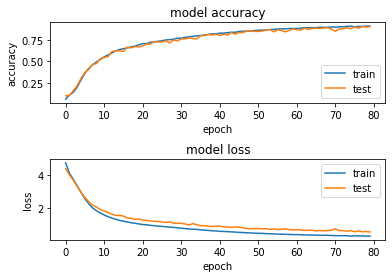

Final Test Accuracy: 0.9161199927330017


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       0.98      1.00      0.99       430
           2       0.99      1.00      1.00       419
           3       0.96      1.00      0.98       384
           4       0.94      1.00      0.97       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       0.96      1.00      0.98       294
           9       0.82      1.00      0.90       269
          10       0.98      1.00      0.99       296
          11       0.99      1.00      0.99       258
          12       1.00      1.00      1.00       247
          13       0.96      1.00      0.98       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os01g0862800         334              334        True
1  Os04g0659100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.045
1,2,0.067
2,3,0.086
3,4,0.542
4,5,0.657
5,6,0.799
6,7,0.874
7,8,0.868
8,9,0.871
9,10,0.909
